In [2]:
#@title Carga de Librerias

#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jUsI1u3bDkgVyIEuVXaxjEMp_VeEKQvc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jUsI1u3bDkgVyIEuVXaxjEMp_VeEKQvc" -O encoder2.zip && rm -rf /tmp/cookies.txt
#!unzip /content/encoder2.zip
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ju7FwlpdeuROeRFjyq34I8UAp6aVwsY6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ju7FwlpdeuROeRFjyq34I8UAp6aVwsY6" -O decoder2.zip && rm -rf /tmp/cookies.txt
#!unzip /content/decoder2.zip
from sklearn.preprocessing import StandardScaler
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import IPython
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
from keras.models import Model
from keras import backend as K
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import pickle
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import random
AUDIO_LOAD = []
etiquetas = []
track_num = []

In [47]:
random.seed(12)

In [ ]:
####importacion de los audios sintetizados
## todas las notas midi 0-127 por las 5 tecnicas de sintesis

In [42]:
DATA_filt = pd.DataFrame()
DATA_filt['data'] = pd.read_pickle('data.pkl')
DATA_filt.head()

,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[-0.00012755481, -0.00027333797, -0.0003318499..."
2,"[-0.012188385, -0.019903447, -0.017293891, -0...."
3,"[-0.08786263, -0.1444907, -0.1269547, -0.13857..."
4,"[0.0022773542, 0.0052165333, 0.0066018347, 0.0..."


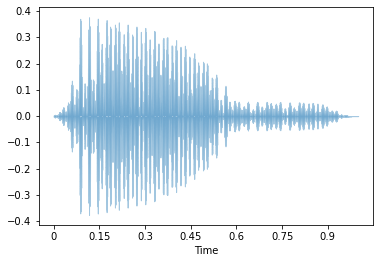

In [39]:
nota = 63
librosa.display.waveshow(DATA_filt['data'][nota], sr=16000, alpha=0.4, label='Original')
IPython.display.display(IPython.display.Audio(DATA_filt['data'][nota], rate = 16000))


In [43]:
data = np.vstack(DATA_filt['data'])
data.shape

mu_wave = np.mean(data, axis= 1)[...,np.newaxis]
max_wave = np.max(data, axis=1)[...,np.newaxis]

Xw = (data- mu_wave)#/max_wave
## para evitar la division entre ceros
Xw = np.divide(Xw, max_wave, out=np.zeros(Xw.shape, dtype=float), where=max_wave!=0)
print(Xw.shape)

Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(640, 16000)
(640, 16000, 1, 1)


In [11]:
##encoder
latent_dim = 128
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vanilla_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
#vae_encoder.summary()

In [12]:
vanilla_encoder.save('/Users/mezaga93/Desktop/vanilla_encoder')


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/vanilla_encoder/assets


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/vanilla_encoder/assets


In [13]:
###decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vanilla_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
#vae_decoder.summary()

In [14]:
vanilla_decoder.save('/Users/mezaga93/Desktop/vanilla_decoder')


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/vanilla_decoder/assets


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/vanilla_decoder/assets


In [ ]:
tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= 5, epochs= 300)

In [52]:
####trainedmodel

Epocas = 3000 
batches = 20 
lr = 0.00008 

warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(lr, clipvalue=0.5)
original_dim = (16000, 1, 1)
encoder_inputs = keras.Input(original_dim)  
encoder_pretrained = tf.keras.models.load_model('/Users/mezaga93/Desktop/dataset_preentreno/encoder2/',compile = False)
decoder_pretrained = tf.keras.models.load_model('/Users/mezaga93/Desktop/dataset_preentreno/decoder2/',compile = False)
outpt = decoder_pretrained(encoder_pretrained(encoder_inputs)[2])
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')


In [53]:
tr_logs = vae.fit(Xw, Xw, shuffle = True, batch_size= batches, epochs= Epocas, verbose = 1)

Epoch 1/3000


2022-10-30 20:37:44.198585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 12s 346ms/step - loss: 0.0132
Epoch 2/3000
32/32 [==============================] - 11s 343ms/step - loss: 0.0126
Epoch 3/3000
32/32 [==============================] - 11s 342ms/step - loss: 0.0125
Epoch 4/3000
32/32 [==============================] - 11s 342ms/step - loss: 0.0124
Epoch 5/3000
32/32 [==============================] - 11s 342ms/step - loss: 0.0124
Epoch 6/3000
32/32 [==============================] - 11s 342ms/step - loss: 0.0124
Epoch 7/3000
32/32 [==============================] - 11s 342ms/step - loss: 0.0124
Epoch 8/3000
32/32 [==============================] - 11s 342ms/step - loss: 0.0125
Epoch 9/3000
32/32 [==============================] - 11s 348ms/step - loss: 0.0126
Epoch 10/3000
32/32 [==============================] - 11s 349ms/step - loss: 0.0126
Epoch 11/3000
32/32 [==============================] - 11s 345ms/step - loss: 0.0126
Epoch 12/3000
32/32 [==============================] - 11s 344ms/step - loss: 0.0126
Ep

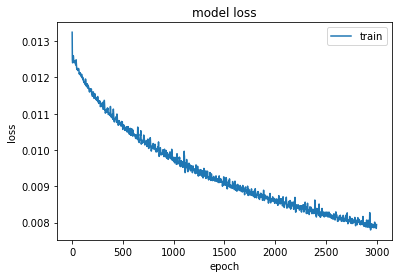

In [54]:
plt.plot(tr_logs.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [55]:
encoder_pretrained.save('/Users/mezaga93/Desktop/encoder2_cdmx')
decoder_pretrained.save('/Users/mezaga93/Desktop/decoder2_cdmx')

INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/encoder2_cdmx/assets


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/encoder2_cdmx/assets


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/decoder2_cdmx/assets


INFO:tensorflow:Assets written to: /Users/mezaga93/Desktop/decoder2_cdmx/assets


In [57]:
with open('/Users/mezaga93/aciml_2022/ACIML/filename.pickle', 'wb') as handle:
    pickle.dump(tr_logs.history['loss'], handle)